In [202]:
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import numpy as np

import nltk
nltk.download(['punkt', 'wordnet','stopwords'])
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report, make_scorer,r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zaplu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zaplu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zaplu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [164]:
plt.rcParams['figure.figsize'] = [16, 10]
colors = sns.color_palette('pastel')

## Project motivation

My aim in this project is to analyze prices of Airbnb listings in Amsterdam, focusing primarily on comparing average prices (per person per night) in different city districts, and trying to identify other price drivers that might be interesting to the visitors of Amsterdam.

The analysis provides a general overview of the Airbnb market in Amsterdam, but can also serve as a guide to all visitors who are interested in where to stay if travelling on budget, or how large is the premium for more central apartments. By using text processing techniques I also analyze user reviews to find out which parts of the city the users think are well-located. I find out that the share of reviews that specifically praise the location is in fact a solid price predictor, as linear relationship is observed between the two variables. Through this analysis I also identify districts that are under or over priced given their location.

Location is obviously one of the main drivers when it comes to renting out an Airbnb apartment, but there are of course many other aspects that impact the prices. My analysis goes beyond just comparing the average prices of different districts. I analyze the listings' names and descriptions in specific districts to answer questions such as how much extra on average one needs to pay if the flat is advertised as luxurious, spacious, cosy, modern,etc., or how large is the premium for having a garden, or very specific to Amsterdam, how much more expensive it is to stay just next to a canal, or on it, in a houseboat.

In summary, I want to answer 3 specific questions:
- compare average price per person per night between different neighborhoods in Amsterdam
- analyze whether the average prices in Amsterdam districts are correlated with the ratio of reviews that specifically praise the flat location
- find out how much extra one needs to pay on average for a flat advertised (in the name or description) as luxurious, spacious, modern, having a garden, being close to a canal, etc.

### 1. Import and explore data
To perform the analysis I import two Airbnb datasets that are publically available on the following website http://insideairbnb.com/get-the-data.html. The `listings` dataframe includes detailed data of all listings in Amsterdam, and the `review` dataframe collects the user reviews. According to the website, both datasets have been compiled as of July 8, 2019.

In [209]:
listings = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv')

In [39]:
listings.shape

(20337, 106)

In [40]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2818,https://www.airbnb.com/rooms/2818,20190708161114,2019-07-09,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi,I'm renting a bedroom (room overlooking the ga...,Quiet Garden View Room & Super Fast WiFi I'm r...,none,"Indische Buurt (""Indies Neighborhood"") is a ne...",...,t,f,strict_14_with_grace_period,f,f,1,0,1,0,2.09
1,20168,https://www.airbnb.com/rooms/20168,20190708161114,2019-07-09,Studio with private bathroom in the centre 1,"Cozy studio on your own private floor, 100% in...",For those who like all facets of city life. In...,"Cozy studio on your own private floor, 100% in...",none,Located just in between famous central canals....,...,f,f,strict_14_with_grace_period,f,f,2,0,2,0,2.45
2,25428,https://www.airbnb.com/rooms/25428,20190708161114,2019-07-09,Lovely apt in City Centre (w.lift) near Jordaan,NaN,"This nicely furnished, newly renovated apt is...","This nicely furnished, newly renovated apt is...",none,NaN,...,f,f,strict_14_with_grace_period,f,f,2,2,0,0,0.17
3,27886,https://www.airbnb.com/rooms/27886,20190708161114,2019-07-09,"Romantic, stylish B&B houseboat in canal district",Stylish and romantic houseboat on fantastic hi...,For a romantic couple: A beautifully restored ...,Stylish and romantic houseboat on fantastic hi...,none,"Central, quiet, safe, clean and beautiful.",...,t,f,strict_14_with_grace_period,f,f,1,0,1,0,2.14
4,28871,https://www.airbnb.com/rooms/28871,20190708161114,2019-07-09,Comfortable double room,NaN,In a monumental house right in the center of A...,In a monumental house right in the center of A...,none,NaN,...,f,f,moderate,f,f,3,0,3,0,2.56


In [41]:
listings.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
summary                                          object
space                                            object
description                                      object
experiences_offered                              object
neighborhood_overview                            object
notes                                            object
transit                                          object
access                                           object
interaction                                      object
house_rules                                      object
thumbnail_url                                   float64
medium_url                                      float64
picture_url                                     

In [42]:
#Columns with missing values
listings.isna().sum().sort_values(ascending=False) 

neighbourhood_group_cleansed                    20337
host_acceptance_rate                            20337
medium_url                                      20337
thumbnail_url                                   20337
xl_picture_url                                  20337
license                                         20323
square_feet                                     19948
monthly_price                                   18916
weekly_price                                    17714
notes                                           11192
host_response_time                               8578
host_response_rate                               8578
host_about                                       8447
access                                           8149
interaction                                      7850
house_rules                                      7656
neighborhood_overview                            6486
transit                                          6214
security_deposit            

In [43]:
reviews.shape

(472846, 6)

In [44]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2818,1191,2009-03-30,10952,Lam,Daniel is really cool. The place was nice and ...
1,2818,1771,2009-04-24,12798,Alice,Daniel is the most amazing host! His place is ...
2,2818,1989,2009-05-03,11869,Natalja,We had such a great time in Amsterdam. Daniel ...
3,2818,2797,2009-05-18,14064,Enrique,Very professional operation. Room is very clea...
4,2818,3151,2009-05-25,17977,Sherwin,Daniel is highly recommended. He provided all...


### 2. Obtain prices per person per night

One of the most important determinant for the renting cost per night is obviously the size of the property, which can be measured either through the area size in squared meters/feet but also in terms of number of people it can accommodate (the two being highly correlated). Rather than knowing about the size-driven price distribution of flats in Amsterdam, our analysis focuses on what is more interesting also for an average user of Airbnb when searching for a place to stay - prices **per person** per night.

In the listings dataset the prices are quoted per night but not necessarily per person, therefore I normalize them before continuing the analysis. From the available data I can extract how many guests are included in the listed price of each property. In some cases the properties can accommodate more people than included in the quoted price, and charge extra costs per each additional person. In my normalization approach I calculate the prices corresponding to the maximum capacity of each property, from which I can infer the price per person per night.

In [45]:
#The columns needed for calculation
listings[['price', 'accommodates', 'guests_included', 'extra_people']].head()

,price,accommodates,guests_included,extra_people
0,$59.00,2,1,$20.00
1,$80.00,2,2,$0.00
2,$125.00,3,2,$10.00
3,$150.00,2,1,$0.00
4,$75.00,2,1,$0.00


In [46]:
#The columns needed for calculation do not have any missing values
listings[['price', 'accommodates', 'guests_included', 'extra_people']].isna().sum()

price              0
accommodates       0
guests_included    0
extra_people       0
dtype: int64

In [47]:
#Convert the prices to numerical variable
price_clean = listings['price'].str.replace("$","").str.replace(',','').astype(float)

In [49]:
#Obtain the number of people that can be accommodated but are not included in the price
extra_space = (listings['accommodates'] - listings['guests_included'])
#Due to inconsistencies in the imported data this number is negative in some rare cases. We floor it to 0.
extra_space = extra_space.apply(lambda x: 0 if x<0 else x)
#-calculate the extra costs
extra_price = extra_space*listings['extra_people'].str.replace("$","").str.replace(',','').astype(float)

In [50]:
#Obtain the price at full capacity and calculate price per person per night
listings['price_pp'] = (price_clean + extra_price) / listings['accommodates']

### 3. Calculate average price in each neighborhood

In the following I analyze the lisitings data specific to different neighborhoods and most importantly calculate the average price in each of them. In order not to compare apples and oranges, I only perform the analysis on the "Entire home/apt' offers that represent the majority of listings in the dataset (~80%). To make results as comparable as possible, I also repeat the analysis only using prices of 2-person apartments (as an additional control of other variables, despite the fact that I already work with prices per person which should adjust for the size). The simple analysis is repeated on different susbets of the original dataset, so it is easiest I implement the process of calculating and visualizing average prices in a function.

In [110]:
#The number of listings in each neighbourhood
listings.groupby('neighbourhood_cleansed').count()['id'].sort_values(ascending = False)

neighbourhood_cleansed
De Baarsjes - Oud-West                    3468
De Pijp - Rivierenbuurt                   2503
Centrum-West                              2317
Centrum-Oost                              1778
Westerpark                                1506
Zuid                                      1425
Oud-Oost                                  1349
Bos en Lommer                             1162
Oostelijk Havengebied - Indische Buurt     966
Oud-Noord                                  613
Watergraafsmeer                            579
IJburg - Zeeburgereiland                   491
Slotervaart                                397
Noord-West                                 363
Noord-Oost                                 279
Buitenveldert - Zuidas                     263
Geuzenveld - Slotermeer                    220
De Aker - Nieuw Sloten                     150
Gaasperdam - Driemond                      142
Osdorp                                     141
Bijlmer-Centrum                      

In [111]:
#The distribution of offer type in the listings dataset
listings.groupby(['room_type'])['id'].count()

room_type
Entire home/apt    16148
Private room        4118
Shared room           71
Name: id, dtype: int64

In [112]:
#The distribution of the apartment size in the listings dataset, measured by the number of people that can be accommodated
listings.groupby(['accommodates'])['id'].count()

accommodates
1       468
2     10978
3      1620
4      6271
5       394
6       411
7        48
8        81
9         8
10       12
11        3
12       11
14        3
16       28
17        1
Name: id, dtype: int64

In [184]:
def price_neighborhood(df, filters = None):
    """" Calculates and visualizes the average price per person per night in each neighborhood. 
    Filters can be applied so the analysis can be repeated on different subsets of the original dataframe.
    
    Parameters
    ----------
    df : DataFrame, detailed data of Airbnb listings including their price per person per night
    filters: dict, column - value pairs used to filter the dataset
    
    Returns
    -------
    None
    """
    
    #Empty Filter
    bools = [True]*df.shape[0]
    
    #Combine all the filters
    if filters:
        for column, value in filters.items():
            additional_filter = (df[column] == value)
            bools = bools & additional_filter

    #Apply the filters
    df_filtered = df[bools]
        
    #Calculate average prices in different neighborhoods
    avg_prices = df_filtered.groupby(['neighbourhood_cleansed'])['price_pp'].mean().sort_values(ascending = False)
    
    #Store them in a dataframe
    avg_prices_df = pd.DataFrame(avg_prices).reset_index()

    #Visualize the results
    sns.barplot(y = 'neighbourhood_cleansed', x = 'price_pp', data = avg_prices_df, orient='h', color= colors[0])
    plt.xlabel('Average Price per Person per Night')
    plt.ylabel('Amsterdam neighborhoods')
    
    return avg_prices_df

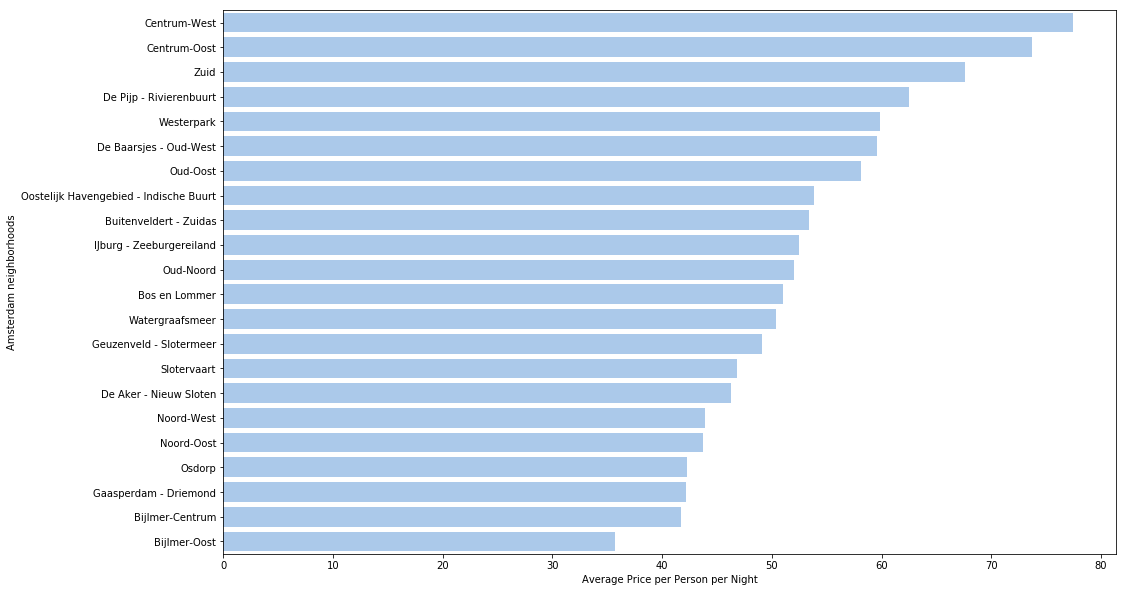

In [191]:
#Average prices for different neighborhoods, all listings
all_avg = price_neighborhood(listings);

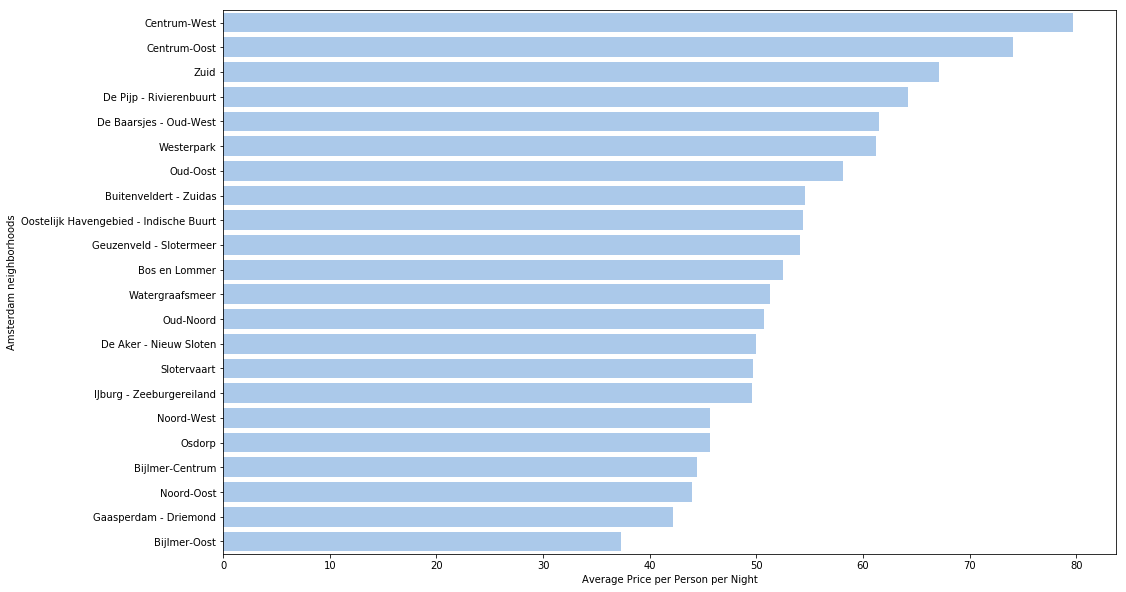

In [192]:
#Average prices for different neighborhoods, entire home/apartment listings only
homeapt_avg = price_neighborhood(listings, {'room_type': 'Entire home/apt'});

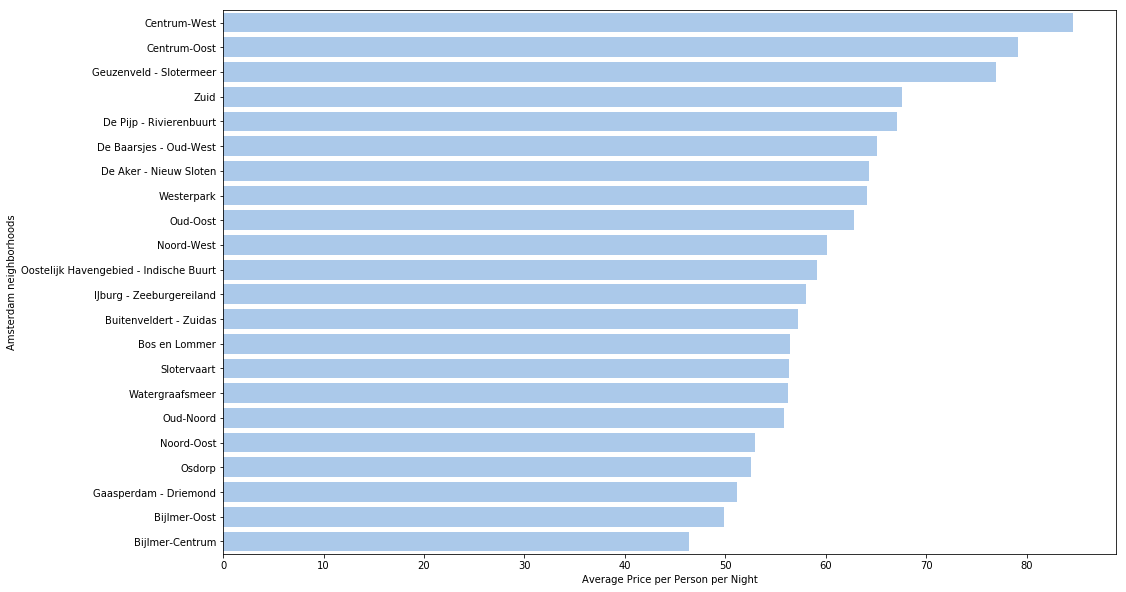

In [193]:
#Average prices for different neighborhoods, entire 2-person home/apartment listings only
homeopt2_avg = price_neighborhood(listings, {'room_type': 'Entire home/apt', 'accommodates':2});

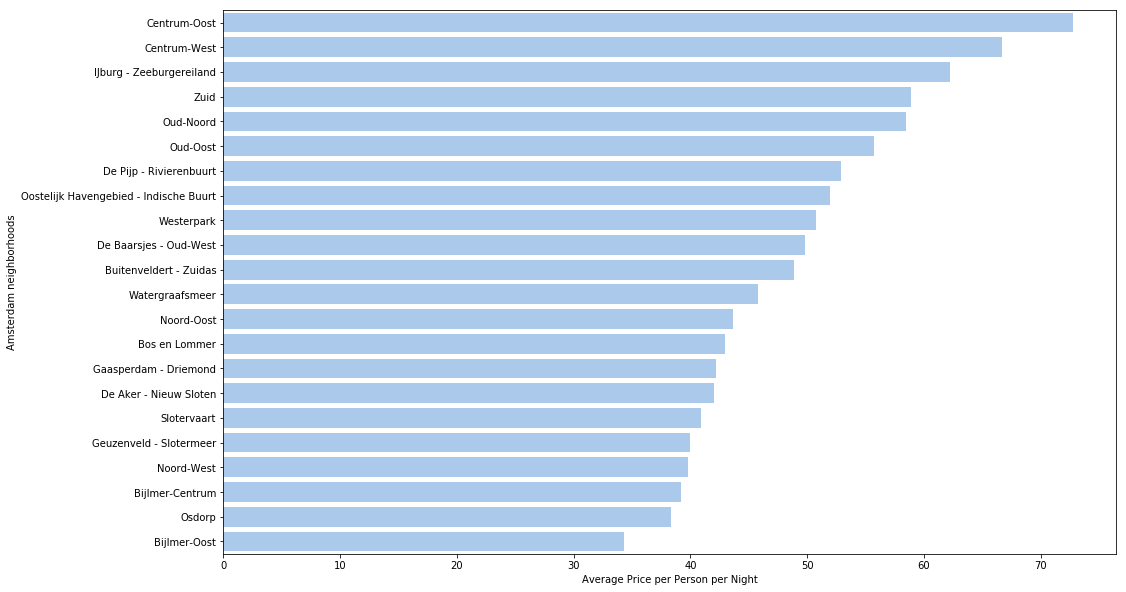

In [194]:
#Average prices for different neighborhoods, private rooms only
private_avg = price_neighborhood(listings, {'room_type': 'Private room'});

#### Observations: 

### 4.  Analyze user reviews
It is common that the user reviews include statements about the flat location. In this part of the analysis I use NLP text processing techniques to extract reviews that include positive comments about the property location, and then obtain, through mapping (user reviews from the `reviews`dataset are mapped to the corresponding listings in the `listings`dataset) and aggregation (listings to neighborhoods), the relative number of positive location reviews in each neighborhood. In this way I can analyze whether the users' opinions about the location are in line with the location-driven price differences, and potentially identify districts that seem under/over-priced given their location.

In [211]:
#Identify missing values
reviews.isna().sum()

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name      0
comments         195
dtype: int64

In [212]:
#Fill in the missing comments
reviews['comments'].fillna('No Comment', inplace = True)

In [213]:
def positive_sentiment(text):
    """" Splits the input text into sentences, and determines whether there exists
    a sentence that includes a positive comment about the flat location.
    
    Parameters
    ----------
    text : str, analyzed user review
    
    Returns
    -------
    positive_flag: boolean, indicates whether the review includes a positive comment about the location
    """
    
    #Split the input text into sentences
    sentences = sent_tokenize(text)
    
    #Clean the sentences and keep the ones that include the keyword 'location'
    sentences_clean = [re.sub(r'[^a-zA-Z0-9]', ' ', sent.lower()).strip() for sent in sentences 
                       if 'location' in sent.lower()]
    
    #In case there are more sentences describing location, merge them together as one long sentence
    one_string = " ".join(sentences_clean)
    
    #Tokenize the sentence into words
    location_words = set(word_tokenize(one_string))
    
    #Define words that represent positive sentiment
    positive_words = ['central', 'good', 'nice', 'best', 'great', 'perfect', 'excellent', 
            'superb', 'amazing', 'awesome', 'incredible', 'wonderful']
    
    #Determine whether the (merged) sentence about the location includes any of the positive words and 
    #excludes the word 'not' 
    if ((len(location_words.intersection(positive_words))  >=1) & ('not' not in location_words)):
        positive_flag = True
    else: 
        positive_flag = False
    
    return positive_flag

In [214]:
#Create a new column that identifies positive location reviews
reviews['positive_location_review'] = reviews['comments'].apply(positive_sentiment)

In [215]:
#Total umber of positive location reviews
reviews['positive_location_review'].sum()

99884

In [216]:
#Total relative number of positive location reviews
reviews['positive_location_review'].sum()/reviews.shape[0]

0.21124002317879395

In [224]:
#Count the number of reviews per listing and number of positive location reviews per listing
review_counts = reviews.groupby('listing_id')['positive_location_review'].count()
positive_review_counts = reviews.groupby('listing_id')['positive_location_review'].sum()

In [252]:
#Store the information into a dataframe
review_counts_df = pd.concat([review_counts, positive_review_counts],axis=1)
review_counts_df.columns = ['total_count','positive_count']
review_counts_df.index.name = 'id'

In [255]:
#Map the newly calculated information to the entries in the listings dataframe
listings_data = listings[['id','neighbourhood_cleansed']]
merged_df = listings_data.merge(review_counts_df, on ='id')

In [256]:
merged_df.head()

,id,neighbourhood_cleansed,total_count,positive_count
0,2818,Oostelijk Havengebied - Indische Buurt,262,19.0
1,20168,Centrum-Oost,279,118.0
2,25428,Centrum-West,3,2.0
3,27886,Centrum-West,195,45.0
4,28871,Centrum-West,277,106.0


In [257]:
#Calculate the total number of reviews per neighborhood and total number of positive location revies per neighborhood
review_counts_nh = merged_df.iloc[:,1:].groupby('neighbourhood_cleansed').sum()
review_counts_nh['positive_location_ratio'] = 100*review_counts_nh['positive_count'] / review_counts_nh['total_count']

In [258]:
#Order the neighborhoods with respect to the ratio of reviews that positively comment on the location
review_counts_nh.sort_values('positive_location_ratio', ascending = False)

,total_count,positive_count,positive_location_ratio
neighbourhood_cleansed,,,
Centrum-West,84873,29137.0,34.330117
Centrum-Oost,55626,16736.0,30.086650
De Pijp - Rivierenbuurt,53086,11868.0,22.356177
De Baarsjes - Oud-West,70674,14870.0,21.040269
Zuid,28086,5772.0,20.551164
Westerpark,30477,5641.0,18.509040
Oud-Oost,23852,3927.0,16.464028
Oud-Noord,14356,1732.0,12.064642
Oostelijk Havengebied - Indische Buurt,19447,2269.0,11.667609


In [261]:
#Combine the dataset with ratio of positive reviews with the dataset that shows average prices
final_results = review_counts_nh.merge(all_avg, on ='neighbourhood_cleansed').sort_values('positive_location_ratio', 
                                                                                          ascending = False)
final_results

,neighbourhood_cleansed,total_count,positive_count,positive_location_ratio,price_pp
5,Centrum-West,84873,29137.0,34.330117,77.488846
4,Centrum-Oost,55626,16736.0,30.086650,73.681415
8,De Pijp - Rivierenbuurt,53086,11868.0,22.356177,62.508626
7,De Baarsjes - Oud-West,70674,14870.0,21.040269,59.562755
21,Zuid,28086,5772.0,20.551164,67.638734
20,Westerpark,30477,5641.0,18.509040,59.869952
17,Oud-Oost,23852,3927.0,16.464028,58.129620
16,Oud-Noord,14356,1732.0,12.064642,52.032267
14,Oostelijk Havengebied - Indische Buurt,19447,2269.0,11.667609,53.863467
2,Bos en Lommer,23161,2440.0,10.534951,51.017163


In [268]:
#Calculate the correlation coefficient between the average prices and the relative number of positive location reviews
print(final_results[['positive_location_ratio', 'price_pp']].corr())
print(final_results[['positive_location_ratio', 'price_pp']].corr('kendall'))

                         positive_location_ratio  price_pp
positive_location_ratio                  1.00000   0.95266
price_pp                                 0.95266   1.00000
                         positive_location_ratio  price_pp
positive_location_ratio                 1.000000  0.792208
price_pp                                0.792208  1.000000


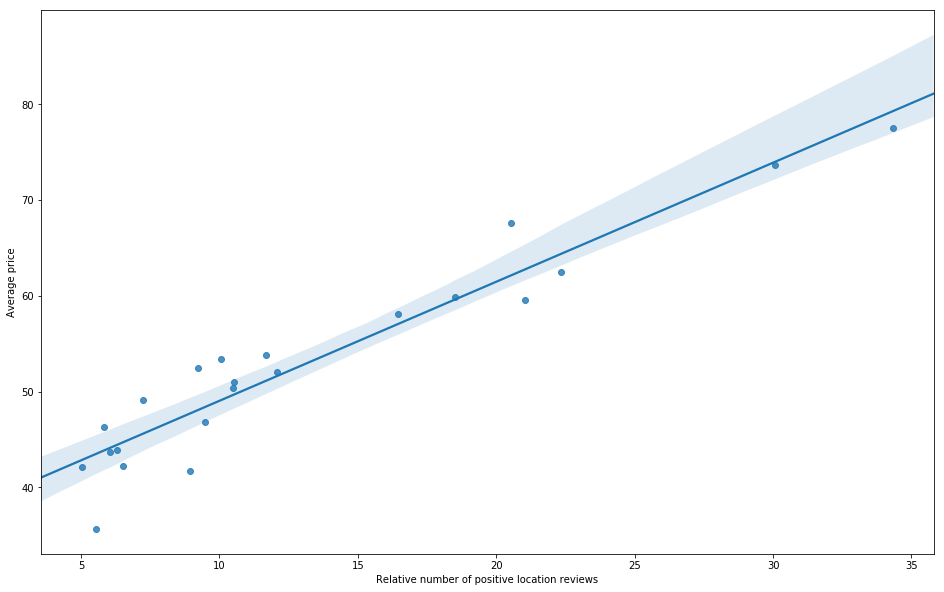

In [277]:
#Show the relationship with a scatter plot
sns.regplot('positive_location_ratio', 'price_pp', data = final_results);
plt.xlabel('Relative number of positive location reviews');
plt.ylabel('Average price');

### Other price drivers

In [96]:
def tokenize(text):
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text.lower())
    tokens = word_tokenize(text)
    
    tokens_subset = [v.strip() for v in tokens if v.strip() not in set(stopwords.words('english'))]
    
    lemmatizer = WordNetLemmatizer()
    lemmed = [lemmatizer.lemmatize(w) for w in tokens_subset]
    
    return lemmed

In [97]:
data['name'] = data['name'].fillna('No Name')
data['description'] = data['description'].fillna('No Description')

In [98]:
iqr = data['price_per'].quantile(0.75) - data['price_per'].quantile(0.25)
lower = data['price_per'].quantile(0.25) - 1.5*iqr
upper = data['price_per'].quantile(0.75) + 1.5*iqr


In [99]:
data.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_clean,price_per
0,2818,https://www.airbnb.com/rooms/2818,20190506125736,43591,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi,I'm renting a bedroom (room overlooking the ga...,Quiet Garden View Room & Super Fast WiFi I'm r...,none,"Indische Buurt (""Indies Neighborhood"") is a ne...",...,strict_14_with_grace_period,f,f,1,0,1,0,2.07,59.0,39.5
1,20168,https://www.airbnb.com/rooms/20168,20190506125736,43591,Studio with private bathroom in the centre 1,"Cozy studio on your own private floor, 100% in...",For those who like all facets of city life. In...,"Cozy studio on your own private floor, 100% in...",none,Located just in between famous central canals....,...,strict_14_with_grace_period,f,f,2,1,1,0,2.39,80.0,40.0
2,25428,https://www.airbnb.com/rooms/25428,20190506125736,43591,Lovely apt in City Centre (Jordaan),NaN,"This nicely furnished, newly renovated apt is...","This nicely furnished, newly renovated apt is...",none,NaN,...,strict_14_with_grace_period,f,f,2,2,0,0,0.13,125.0,45.0
3,27886,https://www.airbnb.com/rooms/27886,20190506125736,43591,"Romantic, stylish B&B houseboat in canal district",Stylish and romantic houseboat on fantastic hi...,For a romantic couple: A beautifully restored ...,Stylish and romantic houseboat on fantastic hi...,none,"Central, quiet, safe, clean and beautiful.",...,strict_14_with_grace_period,f,f,1,0,1,0,2.12,150.0,75.0
4,28658,https://www.airbnb.com/rooms/28658,20190506125736,43591,Cosy guest room near city centre -1,2 beds guest room in Amsterdam West near Erasm...,Cosy small but comfortable guest room with twi...,2 beds guest room in Amsterdam West near Erasm...,none,"The listing is located in Amsterdam west, betw...",...,moderate,t,t,1,0,1,0,4.15,65.0,32.5


In [100]:
count = CountVectorizer(tokenizer = tokenize,max_features = 5000)
counted = count.fit_transform(data['description'])

KeyboardInterrupt: 

In [19]:
tfidf = TfidfTransformer()
tfidfed = tfidf.fit_transform(counted)

In [20]:
#Take only central apartments, only for two people, calculate how the words like close to the canal, stylisth impact the price
#Fix location, fix number of people, fix type of property

In [ ]:
word_count_raw = counted.sum(axis=0)
word_count_mapped = [(word, word_count_raw[0, i]) for word, i in count.vocabulary_.items()]
word_count = pd.DataFrame(word_count_mapped,columns =['word','count']).sort_values(by='count',ascending=False)

In [31]:
word_count[:30]

,word,count
30,apartment,7743
35,amsterdam,4604
115,spacious,2273
14,city,2079
3,room,1941
10,centre,1881
77,house,1680
24,near,1674
36,center,1585
1,garden,1470


In [76]:
data['description'].fillna('No Description',inplace = True)

In [78]:
#tokens_description = data['description'].apply(tokenize)
tokens_name = data['name'].apply(tokenize)

In [79]:
additional_filter = (data['price_per']<250) & ((data['neighbourhood_cleansed']=='Centrum-Oost') | 
                                               (data['neighbourhood_cleansed']=='Centrum-West'))# & (data.accommodates == 2)

bins = np.arange(0,300,5)

KeyError: 'price_per'

In [80]:
results = pd.concat([data[(word==0) & (additional_filter)]['price_per'].describe(),
           data[(word==1) & (additional_filter)]['price_per'].describe()],axis = 1)
results.columns = ['Other','Keyword']
results

NameError: name 'word' is not defined

In [ ]:
plt.rcParams['figure.figsize'] = [18, 10]
i=1
for keyword in ['canal','houseboat','terrace','view','stylish','luxurious','spacious','modern','garden']:
    plt.subplot(3,3,i)
    word = tokens_name.apply(lambda x: 1 if keyword in x else 0)
    sns.distplot(data[(word==1) & additional_filter]['price_per'],
                 bins, kde = True, norm_hist = True)
    print(len(data[(word==1) & additional_filter]))
    sns.distplot(data[(word==0) & additional_filter]['price_per'],
                 bins, kde = True, norm_hist = True, color = 'red')
    plt.title(keyword)
    i+=1

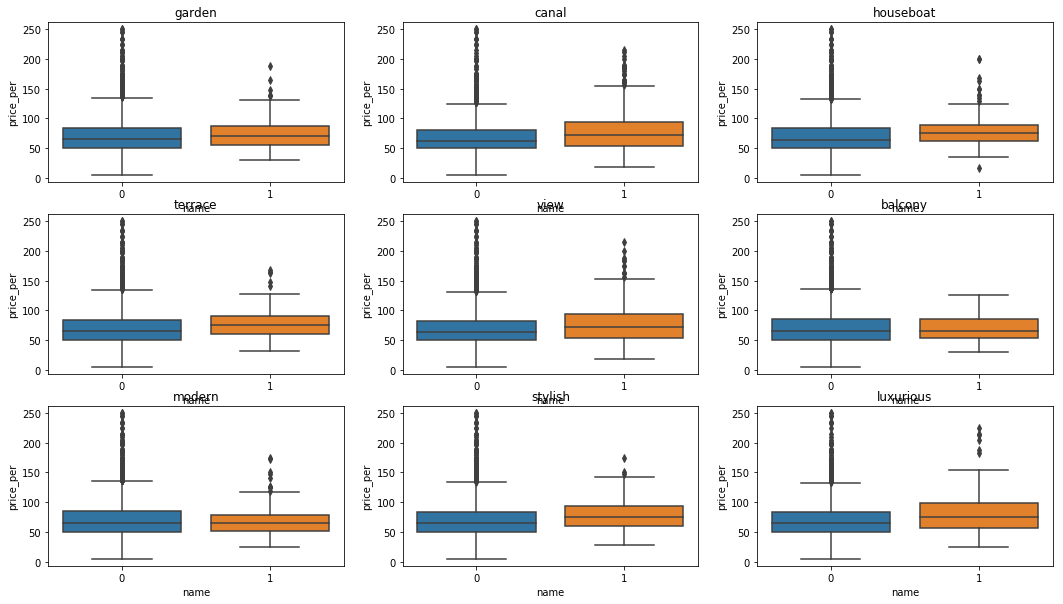

In [54]:
i=1
for keyword in ['garden','canal','houseboat','terrace','view','balcony','modern','stylish','luxurious']:
    plt.subplot(3,3,i)
    word = tokens.apply(lambda x: 1 if keyword in x else 0)
    sns.boxplot(data=pd.concat([data['price_per'],word],axis=1)[additional_filter], x='name',y='price_per')
    plt.title(keyword)
    i+=1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidfed, data['price_per'], test_size = 0.25, random_state = 20)

In [ ]:
classifier = GradientBoostingRegressor()
classifier.fit(X_train,y_train)

In [345]:
r2_score(y_pred,y_pred)

1.0

(array([1.300e+01, 4.700e+01, 1.240e+02, 2.810e+02, 4.820e+02, 1.194e+03,
        7.450e+02, 5.600e+02, 3.330e+02, 2.590e+02, 2.110e+02, 1.990e+02,
        1.360e+02, 9.700e+01, 7.700e+01, 4.100e+01, 3.300e+01, 1.300e+01,
        7.000e+00, 5.000e+00, 5.000e+00, 4.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+0

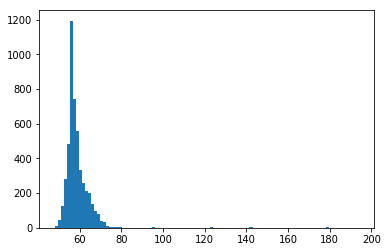

In [341]:
plt.hist(y_pred[y_pred<200],bins=100)

In [84]:
reviews['comments']= reviews['comments'].fillna('No Comment')

In [301]:
reviews['comments'].apply(lambda x: 1 if 'location' in x else 0).sum()

114874

In [376]:
positive_words = pd.Series(['central','good', 'nice', 'best', 'great', 'perfect', 'excellent', 'superb', 'amazing', 'awesome', 'incredible', 'wonderful']) +' location'

In [377]:
sentiment = reviews[['listing_id']]

In [378]:
for word in positive_words:
    sentiment = pd.concat([sentiment, reviews['comments'].apply(lambda x: 1 if word in x else 0)],axis=1)
sentiment.columns =  ['id']+ list(positive_words.values)
#Make it 0 or 1 - if there was one combination of good sentiment give 1

In [379]:
sentiment.iloc[:,1:].sum().sum()

37791

In [380]:
sentiment.sum()

id                     4638160236389
central location                2683
good location                   5861
nice location                   1237
best location                    827
great location                 17429
perfect location                5449
excellent location              1625
superb location                  255
amazing location                1286
awesome location                 350
incredible location              140
wonderful location               649
dtype: int64

In [326]:
positive_reviews = sentiment.iloc[:,1:].sum(axis = 1)
positive_reviews[positive_reviews>1]=1
positive_reviews = pd.concat([sentiment.iloc[:,0],positive_reviews],axis =1 )

In [332]:
number_of_reviews = positive_reviews.groupby('id').count()
number_of_positive_reviews = positive_reviews.groupby('id').sum()

In [333]:
review_data = pd.concat([number_of_reviews, number_of_positive_reviews],axis = 1)
review_data.columns= ['total','positive']

In [334]:
review_data.sort_values('total',ascending = False)

,total,positive
id,,
82482,733,79
43109,683,11
1469096,677,66
1814121,657,4
785432,651,74
68290,624,73
694850,617,72
152280,588,17
654931,577,57


In [335]:
area_data = data[['id','neighbourhood_cleansed']]

In [336]:
merged = area_data.merge(review_data, on ='id')
merged.head()

,id,neighbourhood_cleansed,total,positive
0,2818,Oostelijk Havengebied - Indische Buurt,255,2
1,20168,Centrum-Oost,267,50
2,25428,Centrum-West,2,1
3,27886,Centrum-West,189,9
4,28658,Bos en Lommer,453,24


In [337]:
grouped = merged.iloc[:,1:4].groupby('neighbourhood_cleansed').sum()
grouped['share']= grouped['positive']/grouped['total']

In [338]:
review_final_data = grouped.sort_values('share',ascending = False)

In [339]:
price_data = grouped_data[grouped_data['room_type']=='Entire home/apt'].sort_values('price_per',ascending = False)

In [340]:
review_final_data.merge(price_data, on = 'neighbourhood_cleansed')

,neighbourhood_cleansed,total,positive,share,room_type,price_per
0,Centrum-West,81739,11055,0.135248,Entire home/apt,77.918784
1,Centrum-Oost,54186,6597,0.121747,Entire home/apt,74.200072
2,De Pijp - Rivierenbuurt,50550,4475,0.088526,Entire home/apt,63.260770
3,De Baarsjes - Oud-West,69475,5955,0.085714,Entire home/apt,60.815804
4,Zuid,26392,2130,0.080706,Entire home/apt,66.900596
5,Westerpark,29401,2216,0.075372,Entire home/apt,60.944095
6,Oud-Oost,22351,1399,0.062592,Entire home/apt,57.179670
7,Oostelijk Havengebied - Indische Buurt,18179,796,0.043787,Entire home/apt,53.645287
8,Bos en Lommer,21883,842,0.038477,Entire home/apt,51.850062
9,Watergraafsmeer,9066,348,0.038385,Entire home/apt,50.899624


## Alternative approach

In this context I also analyze user reviews to find out which parts of the city the users think are well-located. 
After mapping them to the flats, we use text processing techniques to find for each flat the reviews that had a positive sentiment about the location of the flat. By aggregating over all flats in a given areas, we can once again compare areas in Amsterdam by comparing relative number of positive location reviews. We find out the share of positive location reviews is linearly related to the average price, but there still are areas that deviate from the linear relationship. 

In [93]:
reviews['comments']= reviews['comments'].fillna('No Comment')
price_data = grouped_data[grouped_data['room_type']=='Entire home/apt'].sort_values('price_per',ascending = False)
positive = ['central','good', 'nice', 'best', 'great', 'perfect', 'excellent', 'superb', 'amazing', 'awesome', 'incredible', 'wonderful']

In [86]:
def positive_sentiment(text):
    text = nltk.sent_tokenize(text)
    text_clean = [re.sub(r'[^a-zA-Z0-9]', ' ', sent.lower()).strip() for sent in text if 'location' in sent.lower()]
    #In case there are more sentences describing location
    one_string = " ".join(text_clean)
    words = set(word_tokenize(one_string))
    if ((len(words.intersection(positive))>=1) & ('not' not in words)):
        return 1
    else: 
        return 0

In [87]:
reviews['positive_review'] = reviews['comments'].apply(positive_sentiment)

In [88]:
reviews['positive_review'].sum()

94604

In [94]:
pos_rev_listing = pd.concat([reviews[['listing_id','positive_review']].groupby('listing_id').count(),
          reviews[['listing_id','positive_review']].groupby('listing_id').sum()],axis=1)

In [95]:
pos_rev_listing.columns = ['total','positive']
pos_rev_listing.index.name = 'id'

In [96]:
area_data = data[['id','neighbourhood_cleansed']]
merged = area_data.merge(pos_rev_listing, on ='id')
final = merged.iloc[:,1:].groupby('neighbourhood_cleansed').sum()
final['positive_ratio'] = 100*final['positive']/final['total']

In [97]:
finalfinal = final.merge(price_data, on ='neighbourhood_cleansed').sort_values('positive_ratio',ascending = False)

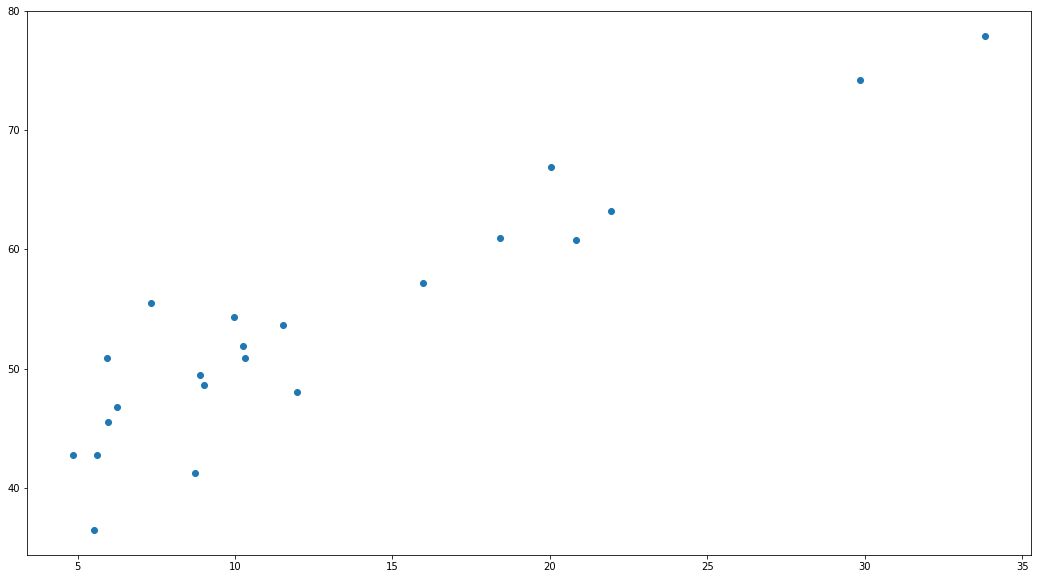

In [98]:
plt.scatter('positive_ratio', 'price_per', data=finalfinal);

In [99]:
finalfinal

,neighbourhood_cleansed,total,positive,positive_ratio,room_type,price_per
5,Centrum-West,81739,27655,33.833299,Entire home/apt,77.918784
4,Centrum-Oost,54186,16180,29.860111,Entire home/apt,74.200072
8,De Pijp - Rivierenbuurt,50550,11096,21.950544,Entire home/apt,63.260770
7,De Baarsjes - Oud-West,69475,14460,20.813242,Entire home/apt,60.815804
21,Zuid,26392,5288,20.036375,Entire home/apt,66.900596
20,Westerpark,29401,5410,18.400735,Entire home/apt,60.944095
17,Oud-Oost,22351,3568,15.963492,Entire home/apt,57.179670
16,Oud-Noord,13448,1611,11.979477,Entire home/apt,47.991150
14,Oostelijk Havengebied - Indische Buurt,18179,2093,11.513285,Entire home/apt,53.645287
19,Watergraafsmeer,9066,935,10.313258,Entire home/apt,50.899624
